# Imports

In [43]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

from time import time as t
import datetime
from tqdm import tqdm

from bindsnet.datasets import MNIST
from bindsnet.encoding import PoissonEncoder
from bindsnet.network import Network, load
from bindsnet.learning import PostPre, WeightDependentPostPre
from bindsnet.network.monitors import Monitor, NetworkMonitor
from bindsnet.network.nodes import AdaptiveLIFNodes, Input
from bindsnet.network.topology import LocalConnection, Connection
from bindsnet.analysis.plotting import (
    plot_input,
    plot_spikes,
    plot_conv2d_weights,
    plot_voltages,
)

from IPython.display import clear_output

%matplotlib inline

UsageError: Line magic function `%%matplotlib` not found.


# Loading and encoding MNIST dataset

In [4]:
time_max = 30
dt = 1
intensity = 127.5

train_dataset = MNIST(
    PoissonEncoder(time=time_max, dt=dt),
    None,
    "MNIST",
    download=False,
    train=True,
    transform=transforms.Compose(
        [transforms.ToTensor(), transforms.Lambda(lambda x: x * intensity)]
    )
)

# Building network

In [14]:
# Hyperparameters 
n_filters = 25
kernel_size = 12
stride = 4 
padding = 0
conv_size = int((28 - kernel_size + 2 * padding) / stride) + 1
per_class = int((n_filters * conv_size * conv_size) / 10)
tc_trace = 20.  # grid search check
tc_decay = 20.
thresh = -52
refrac = 5

wmin = 0
wmax = 1

# Network
network = Network(learning=True)
GlobalMonitor = NetworkMonitor(network, state_vars=('v', 's', 'w'))


input_layer = Input(n=784, shape=(1, 28, 28), traces=True)

output_layer = AdaptiveLIFNodes(
    n=n_filters * conv_size * conv_size,
    shape=(n_filters, conv_size, conv_size),
    traces=True,
    thres=thresh,
    trace_tc=tc_trace,
    tc_decay=tc_decay,
    theta_plus=0.05,
    tc_theta_decay=1e6)


connection_XY = LocalConnection(
    input_layer,
    output_layer,
    n_filters=n_filters,
    kernel_size=kernel_size,
    stride=stride,
    update_rule=PostPre,
    norm=0.4 * kernel_size ** 2,  # norm constant - check
    nu=[1e-4, 1e-2],
    wmin=wmin,
    wmax=wmax)

# competitive connections
w = torch.zeros(n_filters, conv_size, conv_size, n_filters, conv_size, conv_size)
for fltr1 in range(n_filters):
    for fltr2 in range(n_filters):
        if fltr1 != fltr2:
            # change
            for i in range(conv_size):
                for j in range(conv_size):
                    w[fltr1, i, j, fltr2, i, j] = -100.0
                    
connection_YY = Connection(output_layer, output_layer, w=w)

network.add_layer(input_layer, name='X')
network.add_layer(output_layer, name='Y')

network.add_connection(connection_XY, source='X', target='Y')
network.add_connection(connection_YY, source='Y', target='Y')

network.add_monitor(GlobalMonitor, name='Network')

spikes = {}
for layer in set(network.layers):
    spikes[layer] = Monitor(network.layers[layer], state_vars=["s"], time=time_max)
    network.add_monitor(spikes[layer], name="%s_spikes" % layer)
    print('GlobalMonitor.state_vars:', GlobalMonitor.state_vars)

voltages = {}
for layer in set(network.layers) - {"X"}:
    voltages[layer] = Monitor(network.layers[layer], state_vars=["v"], time=time_max)
    network.add_monitor(voltages[layer], name="%s_voltages" % layer)

GlobalMonitor.state_vars: ('v', 's', 'w')
GlobalMonitor.state_vars: ('v', 's', 'w')


# Training

In [ ]:
visualize = False
n_train = 1
for epoch in range(n_train):
    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True)
    
    for batch in tqdm(train_dataloader):
        inpts = {"X": batch["encoded_image"]}
        inpts = {"X": batch["encoded_image"].transpose(0, 1)}

        network.run(inpts=inpts, time=time_max, input_time_dim=1)
    network.reset_()  # Reset state variables

# Saving network

In [ ]:
network.save(f'network_{str(datetime.datetime.today())}'[:-7].replace(' ', '_').replace(':', '-'))

# Locking network

In [ ]:
network.train(False);

# Loading network

In [ ]:
network = load('default', learning=False)

# Testing network

  0%|          | 0/60000 [00:00<?, ?it/s]D:\Programs\Anaconda3\envs\lab37\lib\site-packages\ipykernel_launcher.py:47: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


<Figure size 432x288 with 0 Axes>

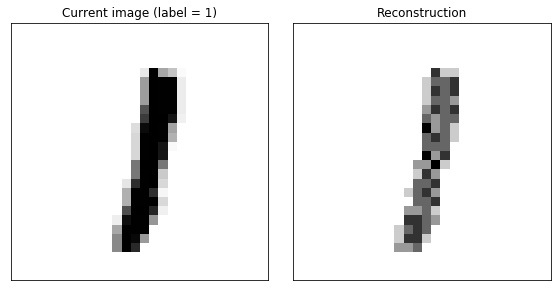

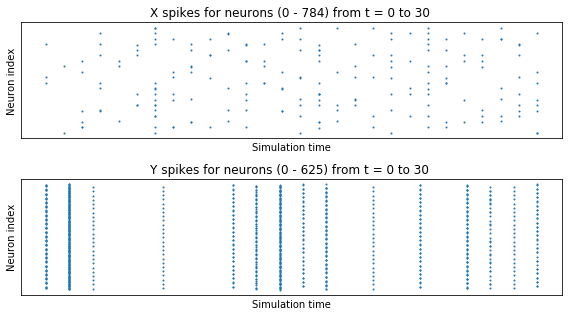

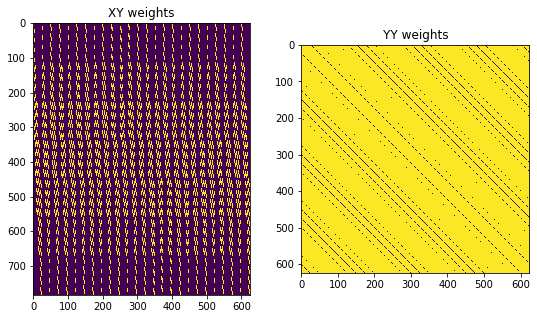

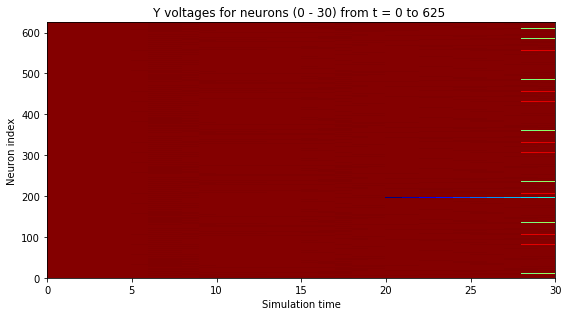

In [45]:
plot = True
n_test = 1
max_test_iterations = 100
plt.figure()
for epoch in range(n_test):
    test_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=1, shuffle=True)

    for batch in tqdm(test_dataloader):
        #Processing
        inpts = {"X": batch["encoded_image"]}
        inpts = {"X": batch["encoded_image"].transpose(0, 1)}
        label = batch["label"]
        network.run(inpts=inpts, time=time_max, input_time_dim=1)
        
        #Visualization
        # Optionally plot various simulation information.
        if plot:
            inpt_axes = None
            inpt_ims = None
            spike_ims = None
            spike_axes = None
            weights1_im = None
            voltage_ims = None
            voltage_axes = None
            image = batch["image"].view(28, 28)

            inpt = inpts["X"].view(time_max, 784).sum(0).view(28, 28)
            weights_XY = connection_XY.w
            weights_YY = connection_YY.w
            
            _spikes = {
                "X": spikes["X"].get("s").view(time_max, -1),
                "Y": spikes["Y"].get("s").view(time_max, -1),
            }
            _voltages = {"Y": voltages["Y"].get("v").view(time_max, -1)}

            inpt_axes, inpt_ims = plot_input(
                image, inpt, label=label, axes=inpt_axes, ims=inpt_ims
            )
            spike_ims, spike_axes = plot_spikes(_spikes, ims=spike_ims, axes=spike_axes)
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
            ax1.imshow(weights_XY.numpy())
            ax1.set_title('XY weights')
            ax2.imshow(weights_YY.reshape(5*5*25, 5*5*25).numpy())
            ax2.set_title('YY weights')
            f.show()
            #weights1_im = plot_conv2d_weights(weights1, im=weights1_im)
            voltage_ims, voltage_axes = plot_voltages(
                _voltages, ims=voltage_ims, axes=voltage_axes
            )

            plt.pause(1)
        
        #clear_output(wait=True)
        break

    network.reset_()  # Reset state variables

TypeError: transpose() takes 2 positional arguments but 3 were given